<a href="https://colab.research.google.com/github/ShirFah/HomeWork4/blob/main/Welcome_To_Colaboratory.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!git clone https://github.com/timesler/facenet-pytorch.git facenet_pytorch


Cloning into 'facenet_pytorch'...
remote: Enumerating objects: 1267, done.
remote: Total 1267 (delta 0), reused 0 (delta 0), pack-reused 1267
Receiving objects: 100% (1267/1267), 22.88 MiB | 36.67 MiB/s, done.
Resolving deltas: 100% (620/620), done.


In [3]:
%cd /content/facenet_pytorch

/content/facenet_pytorch


In [4]:
!pip install mmcv
!pip install opencv-python

     |████████████████████████████████| 537 kB 5.3 MB/s 
     |████████████████████████████████| 190 kB 62.3 MB/s 
  Created wheel for mmcv: filename=mmcv-1.5.1-py2.py3-none-any.whl size=817971 sha256=10f864d37b244778cc03604d6d161e06b227d9c5eb60a699589a322996fd11a4
  Stored in directory: /root/.cache/pip/wheels/7e/13/34/79ae316926b309574ce9b81376dd860dea766bcaa7c68d85fb
Successfully built mmcv


In [4]:
from facenet_pytorch import MTCNN, InceptionResnetV1
import torch
from torch.utils.data import DataLoader
from torchvision import datasets
import numpy as np
import pandas as pd
import os

workers = 0 if os.name == 'nt' else 4

In [5]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Running on device: {}'.format(device))

Running on device: cpu


In [6]:
mtcnn = MTCNN(
    image_size=160, margin=0, min_face_size=20,
    thresholds=[0.6, 0.7, 0.7], factor=0.709, post_process=True,
    device=device
)

In [7]:
resnet = InceptionResnetV1(pretrained='vggface2').eval().to(device)

  0%|          | 0.00/107M [00:00<?, ?B/s]

In [8]:
!rm -rf "find -type d -name .ipynb_checkpoints"

In [9]:
def collate_fn(x):
    return x[0]

dataset = datasets.ImageFolder('data/test_images')
dataset.idx_to_class = {i:c for c, i in dataset.class_to_idx.items()}
loader = DataLoader(dataset, collate_fn=collate_fn, num_workers=workers)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


# New Section

In [10]:
aligned = []
names = []
for x, y in loader:
    x_aligned, prob = mtcnn(x, return_prob=True)
    if x_aligned is not None:
        print('Face detected with probability: {:8f}'.format(prob))
        aligned.append(x_aligned)
        names.append(dataset.idx_to_class[y])

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


Face detected with probability: 0.999983
Face detected with probability: 0.999934
Face detected with probability: 0.999733
Face detected with probability: 0.999880
Face detected with probability: 0.999992


In [11]:
aligned = torch.stack(aligned).to(device)
embeddings = resnet(aligned).detach().cpu()

In [12]:
dists = [[(e1 - e2).norm().item() for e2 in embeddings] for e1 in embeddings]
print(pd.DataFrame(dists, columns=names, index=names))

                angelina_jolie  bradley_cooper  kate_siegel  paul_rudd  \
angelina_jolie        0.000000        1.447480     0.887728   1.429847   
bradley_cooper        1.447480        0.000000     1.313749   1.013447   
kate_siegel           0.887728        1.313749     0.000000   1.388377   
paul_rudd             1.429847        1.013447     1.388377   0.000000   
shea_whigham          1.399073        1.038684     1.379654   1.100503   

                shea_whigham  
angelina_jolie      1.399073  
bradley_cooper      1.038684  
kate_siegel         1.379654  
paul_rudd           1.100503  
shea_whigham        0.000000  


Face Tracking

In [5]:
from facenet_pytorch import MTCNN
import torch
import numpy as np
import mmcv, cv2
from PIL import Image, ImageDraw
from IPython import display

In [6]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Running on device: {}'.format(device))

Running on device: cuda:0


In [7]:
mtcnn = MTCNN(keep_all=True, device=device)

In [8]:

!dir

codecov.yml  dependencies  __init__.py	models	     README.md	tests
data	     examples	   LICENSE.md	__pycache__  setup.py


In [13]:
video = mmcv.VideoReader('examples/video.mp4')
video2 = mmcv.VideoReader('examples/video2.mp4')
frames = [Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)) for frame in video]
frames2 = [Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)) for frame in video2]
#display.Video('video.mp4', width=640)

In [10]:
frames_tracked = []
for i, frame in enumerate(frames):
    print('\rTracking frame: {}'.format(i + 1), end='')
    
    # Detect faces
    boxes, _ = mtcnn.detect(frame)
    
    # Draw faces
    frame_draw = frame.copy()
    draw = ImageDraw.Draw(frame_draw)
    for box in boxes:
        draw.rectangle(box.tolist(), outline=(255, 0, 0), width=6)
    
    # Add to frame list
    frames_tracked.append(frame_draw.resize((640, 360), Image.BILINEAR))
print('\nDone')

Tracking frame: 1

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


Tracking frame: 105
Done


In [14]:
frames_tracked2 = []
for i, frame in enumerate(frames2):
    print('\rTracking frame: {}'.format(i + 1), end='')
    
    # Detect faces
    boxes, _ = mtcnn.detect(frame)
    
    # Draw faces
    frame_draw = frame.copy()
    draw = ImageDraw.Draw(frame_draw)
    for box in boxes:
        draw.rectangle(box.tolist(), outline=(255, 0, 0), width=6)
    
    # Add to frame list
    frames_tracked2.append(frame_draw.resize((640, 360), Image.BILINEAR))
print('\nDone')

Tracking frame: 1

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


Tracking frame: 101

TypeError: ignored

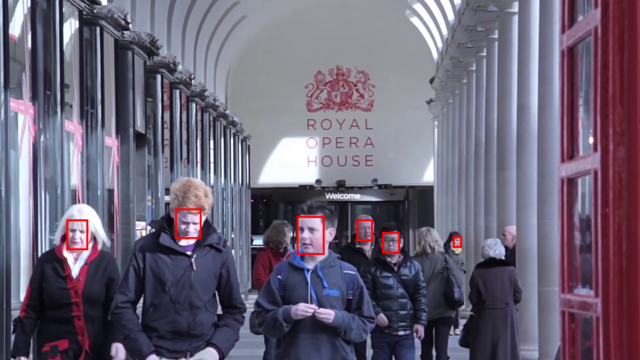

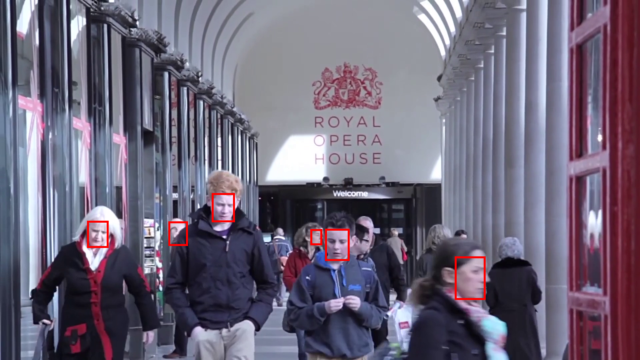

In [11]:
d = display.display(frames_tracked[0], display_id=True)
i = 1
try:
    while True:
        d.update(frames_tracked[i % len(frames_tracked)])
        i += 1
except KeyboardInterrupt:
    pass

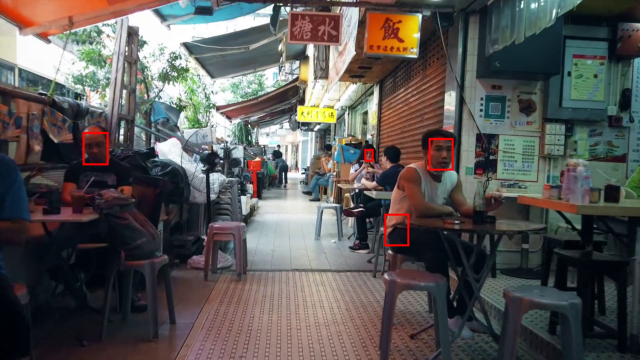

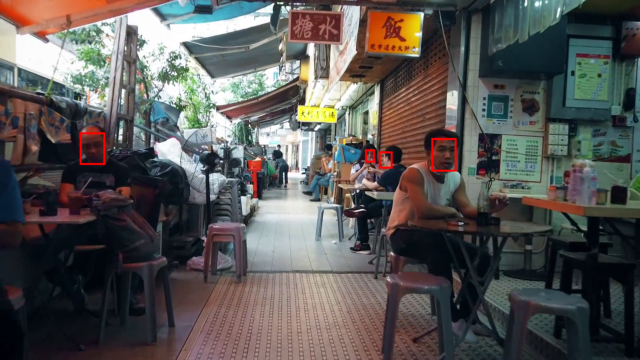

In [ ]:
d = display.display(frames_tracked2[0], display_id=True)
i = 1
try:
    while True:
        d.update(frames_tracked2[i % len(frames_tracked2)])
        i += 1
except KeyboardInterrupt:
    pass